# libraries

In [1]:
import pandas as pd
import numpy as np
import patsy
# import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

# Load Data

## Match-Level Data

In [8]:
import requests

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
    "Referer": "https://www.google.com/"
}

url_df = 'https://fbref.com/en/comps/9/2022-2023/schedule/2022-2023-Premier-League-Scores-and-Fixtures'

try:
    resp = requests.get(url_df, headers=headers, timeout=10)
    resp.raise_for_status()  # raises HTTPError for 4xx/5xx
    df = pd.read_html(resp.text)[0]
except requests.exceptions.HTTPError as e:
    print("HTTP error:", e, resp.status_code)
    print("Response headers:", resp.headers)
    raise
except Exception as e:
    print("Other error:", e)
    raise

C:\Users\tavakola\AppData\Local\Temp\1\ipykernel_20680\2121638218.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(resp.text)[0]


In [9]:
df

,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes
0,1.0,Fri,2022-08-05,20:00,Crystal Palace,1.2,0–2,1.0,Arsenal,25286.0,Selhurst Park,Anthony Taylor,Match Report,NaN
1,1.0,Sat,2022-08-06,12:30,Fulham,1.2,2–2,1.2,Liverpool,22207.0,Craven Cottage,Andy Madley,Match Report,NaN
2,1.0,Sat,2022-08-06,15:00,Newcastle Utd,1.7,2–0,0.3,Nott'ham Forest,52245.0,St James' Park,Simon Hooper,Match Report,NaN
3,1.0,Sat,2022-08-06,15:00,Bournemouth,0.6,2–0,0.7,Aston Villa,11013.0,Vitality Stadium,Peter Bankes,Match Report,NaN
4,1.0,Sat,2022-08-06,15:00,Leeds United,0.8,2–1,1.3,Wolves,36347.0,Elland Road,Robert Jones,Match Report,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,38.0,Sun,2023-05-28,16:30,Aston Villa,2.8,2–1,1.4,Brighton,NaN,Villa Park,David Coote,Match Report,NaN
426,38.0,Sun,2023-05-28,16:30,Leeds United,1.5,1–4,2.2,Tottenham,36871.0,Elland Road,Anthony Taylor,Match Report,NaN
427,38.0,Sun,2023-05-28,16:30,Arsenal,2.8,5–0,0.5,Wolves,60095.0,Emirates Stadium,Andre Marriner,Match Report,NaN
428,38.0,Sun,2023-05-28,16:30,Manchester Utd,2.9,2–1,1.8,Fulham,73465.0,Old Trafford,Robert Jones,Match Report,NaN


In [7]:
# 2022-2023 Premier League Scores and Fixtures
url_df = 'https://fbref.com/en/comps/9/2022-2023/schedule/2022-2023-Premier-League-Scores-and-Fixtures'

df = pd.read_html(url_df)[0]
df['Season'] = '2022-2023'
df = df.dropna(subset=['Date'])

# 2023-2024 Premier League Scores and Fixtures
url_df = 'https://fbref.com/en/comps/9/2023-2024/schedule/2023-2024-Premier-League-Scores-and-Fixtures'
df2 = pd.read_html(url_df)[0]
df2['Season'] = '2023-2024'
df2 = df2.dropna(subset=['Date'])

# 2024-2025 Premier League Scores and Fixtures
url_df = 'https://fbref.com/en/comps/9/2024-2025/schedule/2024-2025-Premier-League-Scores-and-Fixtures'
df3 = pd.read_html(url_df)[0]
df3['Season'] = '2024-2025'
df3 = df3.dropna(subset=['Date'])

# 2025-2026 Premier League Scores and Fixtures
url_df = 'https://fbref.com/en/comps/9/schedule/Premier-League-Scores-and-Fixtures'
df4 = pd.read_html(url_df)[0]
df4['Season'] = '2025-2026'
df4 = df4.dropna(subset=['Date'])

# Combine all seasons into one DataFrame
df = pd.concat([df, df2, df3, df4], ignore_index=True)
match_df = df.drop(columns=['Venue', 'Match Report', 'Notes'])

HTTPError: HTTP Error 403: Forbidden

## Load the Player-Level Data

Note that we use the overall **previous season** performance to predict future results

In [3]:
# 2021-2022 Big 5 European Leagues Player Stats
url_df = 'https://fbref.com/en/comps/Big5/2021-2022/stats/players/2021-2022-Big-5-European-Leagues-Stats'
df = pd.read_html(url_df)[0]
df['Season'] = '2022-2023'

# 2022-2023 Big 5 European Leagues Player Stats
url_df = 'https://fbref.com/en/comps/Big5/2022-2023/stats/players/2022-2023-Big-5-European-Leagues-Stats'
df2 = pd.read_html(url_df)[0]
df2['Season'] = '2023-2024'

# 2023-2024 Big 5 European Leagues Player Stats
url_df = 'https://fbref.com/en/comps/Big5/2023-2024/stats/players/2023-2024-Big-5-European-Leagues-Stats'
df3 = pd.read_html(url_df)[0]
df3['Season'] = '2024-2025'

# 2024-2025 Big 5 European Leagues Player Stats
url_df = 'https://fbref.com/en/comps/Big5/2024-2025/stats/players/2023-2024-Big-5-European-Leagues-Stats'
df4 = pd.read_html(url_df)[0]
df4['Season'] = '2025-2026'

player_df = pd.concat([df, df2, df3, df4], ignore_index=True)

# Clean Data

## Player-Level Data

High-quality players will make a difference. I identify top players in each position based on their average goals and assist reduced by number penalty goals per 90 minutes. Then, I aggregate the number of players in each position-squad to create a measure of squad quality.

In [4]:
df = player_df.copy()

# rename columns to avoid multi-index label
# remove the first part of the multi-index if it contains 'unnamed'
df.columns = [col[1] if 'unnamed' in col[0].lower() else col for col in df.columns]
df.columns = ['Per90_' + col[1] if 'per 90' in col[0].lower() else col for col in df.columns]
df.columns = ['PT_' + col[1] if 'playing time' in col[0].lower() else col for col in df.columns]
df.columns = [col[1] if 'progression' in col[0].lower() else col for col in df.columns]
df.columns = [col[1] if 'performance' in col[0].lower() else col for col in df.columns]
df.columns = [col[1] if 'expected' in col[0].lower() else col for col in df.columns]
df.columns = [col[0] if 'season' in col[0].lower() else col for col in df.columns]

df['Comp'] = df['Comp'].replace({'eng Premier League': 'EPL',
                                 'fr Ligue 1': 'Ligue 1',
                                'it Serie A': 'Serie A',
                                'de Bundesliga': 'Bundesliga',
                                'es La Liga': 'La Liga'})
# keep only players from the English Premier League (EPL)
df = df[df['Comp'] == 'EPL']

# drop unused columns
df = df.drop(columns=['Rk', 'Born', 'Comp', 'Matches'])


# remove the nations's abbreviation from the player's nation. All the characters before the first capital letter
df['Nation'] = df['Nation'].str.extract(r'([A-Z]{3})', expand=False)

# rank players by position and season based on their Per90_G+A-PK
df['Position'] = df['Pos'].str.split(',').str[0]  # take only the first position if multiple

# rank players by position and season based on their Per90_G+A-PK
df['Per90_G+A-PK'] = df['Per90_G+A-PK'].astype(float)
df['Rank'] = df.groupby(['Season', 'Position'])['Per90_G+A-PK'].rank(ascending=False, method='min').astype(int)
df = df.sort_values(['Season', 'Position', 'Rank'])

# partition players into quartiles based on their Per90_G+A-PK by position and season
df['Quartile'] = df.groupby(['Season', 'Position'])['Per90_G+A-PK'].transform(
    lambda x: pd.qcut(x, 4, labels=False, duplicates='drop'))

df = df.groupby(['Season', 'Position', 'Squad', 'Quartile']).agg( num_players = ('Player', 'nunique') ).reset_index()

# pivot the dataframe to have positions-quartiles as columns and seasons and squads as index
num_fw_by_ga_pk = df[df['Position'].isin(['FW'])].copy()
num_fw_by_ga_pk = num_fw_by_ga_pk.pivot_table(index=['Season', 'Squad'], columns=['Quartile'], values='num_players', fill_value=0).reset_index()

num_mf_by_ga_pk = df[df['Position'].isin(['MF'])].copy()
num_mf_by_ga_pk = num_mf_by_ga_pk.pivot_table(index=['Season', 'Squad'], columns=['Quartile'], values='num_players', fill_value=0).reset_index()

num_df_by_ga_pk = df[df['Position'].isin(['DF'])].copy()
num_df_by_ga_pk = num_df_by_ga_pk.pivot_table(index=['Season', 'Squad'], columns=['Quartile'], values='num_players', fill_value=0).reset_index()

## Match-Level Data

## Function - Clearning

In [5]:
def team_view(df):
    # home perspective
    home = pd.DataFrame({
        'Season': df['Season'],
        'MatchID': df['MatchID'],
        'Date': df['Date'],
        'year': df['year'],
        'month': df['month'],
        'day': df['day'],
        'DayofWeek': df['Day'],
        'Team': df['Home'],
        'TeamID': df.get('HomeTeamID'),
        'OpponentID': df.get('AwayTeamID'),
        'IsHome': True,
        'GoalsFor': df.get('FullTimeHomeGoals'),
        'GoalsAgainst': df.get('FullTimeAwayGoals'),
        'Shots': df.get('HomeShots'),
        'ShotsOnTarget': df.get('HomeShotsOnTarget'),
        'Corners': df.get('HomeCorners'),
        'Fouls': df.get('HomeFouls'),
        'YellowCards': df.get('HomeYellowCards'),
        'RedCards': df.get('HomeRedCards'),
        'ShotsAgainst': df.get('AwayShots'),
        'ShotsOnTargetAgainst': df.get('AwayShotsOnTarget'),
        'CornersAgainst': df.get('AwayCorners'),
        'FoulsAgainst': df.get('AwayFouls'),
        'YellowCardsAgainst': df.get('AwayYellowCards'),
        'RedCardsAgainst': df.get('AwayRedCards'),
        'HalfTimeResult': df.get('HalfTimeResult')
    })
    # away perspective
    away = pd.DataFrame({
        'Season': df['Season'],
        'MatchID': df['MatchID'],
        'Date': df['Date'],
        'year': df['year'],
        'month': df['month'],
        'day': df['day'],
        'DayofWeek': df['Day'],
        'Team': df.get('Away'),
        'TeamID': df.get('AwayTeamID'),
        'OpponentID': df.get('HomeTeamID'),
        'IsHome': False,
        'GoalsFor': df.get('FullTimeAwayGoals'),
        'GoalsAgainst': df.get('FullTimeHomeGoals'),
        'Shots': df.get('AwayShots'),
        'ShotsOnTarget': df.get('AwayShotsOnTarget'),
        'Corners': df.get('AwayCorners'),
        'Fouls': df.get('AwayFouls'),
        'YellowCards': df.get('AwayYellowCards'),
        'RedCards': df.get('AwayRedCards'),
        'ShotsAgainst': df.get('HomeShots'),
        'ShotsOnTargetAgainst': df.get('HomeShotsOnTarget'),
        'CornersAgainst': df.get('HomeCorners'),
        'FoulsAgainst': df.get('HomeFouls'),
        'YellowCardsAgainst': df.get('HomeYellowCards'),
        'RedCardsAgainst': df.get('HomeRedCards'),
        'HalfTimeResult': df.get('HalfTimeResult')
    })

    df = pd.concat([home, away], ignore_index=True).sort_values(['Season', 'TeamID', 'MatchID']).reset_index(drop=True)

    # sort the data by team ID and match ID and create a new variable indicating the teams' game number since beginning of each season
    df['Week'] = df.groupby(['Season', 'TeamID']).cumcount() + 1
    df['Week'] = df['Week'].astype(int)

    return df
# add outcome from full-time scores (W/L/D from each team's perspective)
def wl_from_scores(row):
    gf = row['GoalsFor']
    ga = row['GoalsAgainst']
    if pd.isna(gf) or pd.isna(ga):
        return None
    if gf > ga:
        return 'W'
    if gf < ga:
        return 'L'
    return 'D'

def points_from_scores(row):
    gf = row['GoalsFor']
    ga = row['GoalsAgainst']
    if pd.isna(gf) or pd.isna(ga):
        return None
    if gf > ga:
        return 3
    if gf < ga:
        return 0
    return 1

In [6]:
# clean the match-level data
df = match_df.copy()

## split the Date into a year, month and date
df['year']  = [int(d.split("-")[0]) for d in df.Date]
df['month'] = [int(d.split("-")[1]) for d in df.Date]
df['day']   = [int(d.split("-")[2]) for d in df.Date]

df['FullTimeHomeGoals'] = [np.nan if pd.isna(x) else int(x.split("–")[0].strip()) for x in df['Score']]
df['FullTimeAwayGoals'] = [np.nan if pd.isna(x) else int(x.split("–")[1].strip()) for x in df['Score']]

## create a stable unique ID for every team (covers Home and Away)
teams = sorted(
    set(df['Home'].dropna().unique()).union(set(df['Away'].dropna().unique()))
)

team_to_id = {name: i for i, name in enumerate(teams, start=1)}


# add ID columns to the match dataframe
df['HomeTeamID'] = df['Home'].map(team_to_id)
df['AwayTeamID'] = df['Away'].map(team_to_id)

# ensure a stable match id
df = df.reset_index(drop=True)
df['MatchID'] = df.index + 1

long_df = team_view(df)

long_df['Outcome']  = long_df.apply(wl_from_scores, axis=1)
long_df['Points']   = long_df.apply(points_from_scores, axis=1)

# optional: reorder columns
cols = ['Season', 'MatchID','Date', 'Week', 'DayofWeek','Team','TeamID','IsHome',
        'GoalsFor','GoalsAgainst','Outcome', 'Points']
long_df = long_df[[c for c in cols if c in long_df.columns]]

#For each team-match observation create the lag of each variable
cols = ['IsHome','GoalsFor','GoalsAgainst','Points']

for c in cols:
    long_df[f'{c}_lag1'] = long_df.groupby(['Season', 'TeamID'])[c].shift(1)

# optional: create a 3-game rolling mean (uses previous games only)
num_cols = [c for c in cols if pd.api.types.is_numeric_dtype(long_df[c])]
for c in num_cols:
    long_df[f'{c}_roll3'] = long_df.groupby(['Season', 'TeamID'])[c].transform(
        lambda s: s.shift(1).rolling(3, min_periods=1).mean()
    )

# merge the player-level data (num_fw_by_ga_pk) into the match-level data (long_df)
long_df = long_df.merge(num_fw_by_ga_pk,
                        left_on=['Season', 'Team'],
                        right_on=['Season', 'Squad'],
                        how='left')
long_df = long_df.rename(columns={0:'FW_Q1', 1:'FW_Q2', 2:'FW_Q3', 3:'FW_Q4'})
long_df = long_df.drop(columns=['Squad'])
long_df['FW_Q1'] = long_df['FW_Q1'].fillna(0)
long_df['FW_Q2'] = long_df['FW_Q2'].fillna(0)
long_df['FW_Q3'] = long_df['FW_Q3'].fillna(0)
long_df['FW_Q4'] = long_df['FW_Q4'].fillna(0)
long_df = long_df.merge(num_mf_by_ga_pk,
                        left_on=['Season', 'Team'],
                        right_on=['Season', 'Squad'],
                        how='left')
long_df = long_df.rename(columns={0:'MF_Q1', 1:'MF_Q2', 2:'MF_Q3', 3:'MF_Q4'})
long_df = long_df.drop(columns=['Squad'])
long_df['MF_Q1'] = long_df['MF_Q1'].fillna(0)
long_df['MF_Q2'] = long_df['MF_Q2'].fillna(0)
long_df['MF_Q3'] = long_df['MF_Q3'].fillna(0)

In [7]:
long_df.Points_roll3.describe()

count    2440.000000
mean        1.386885
std         0.874604
min         0.000000
25%         0.666667
50%         1.333333
75%         2.000000
max         3.000000
Name: Points_roll3, dtype: float64

## Player-Team Panel

To track players movement across teams/league, I create a player-team panel.

1. Define universal player ID and team ID.
2. Sort the data by player, team, season. If your current team is different than previous team, transfer = 1, ow = 0
3. If player is not the data for a one or more years, fill in the gaps. Label League and Team as 0 (out of top 5 league).
4. For each team, aggregate the number of inbound and outbound transfers.
5. Identify the quality of players based on their within league performance. Were they within the top player in their own league the season before moving?

# Data Exploration

Histogram of winning against the rolling average number of goals for

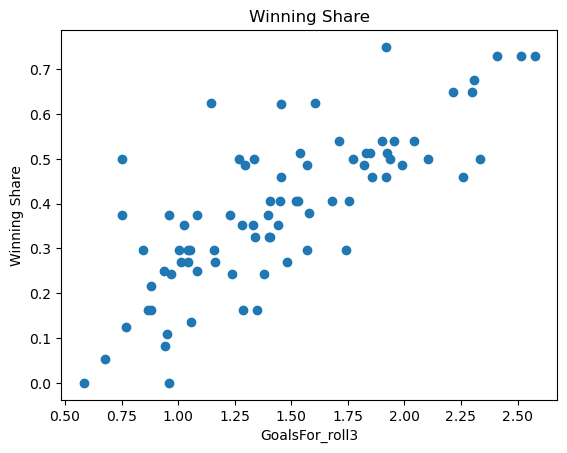

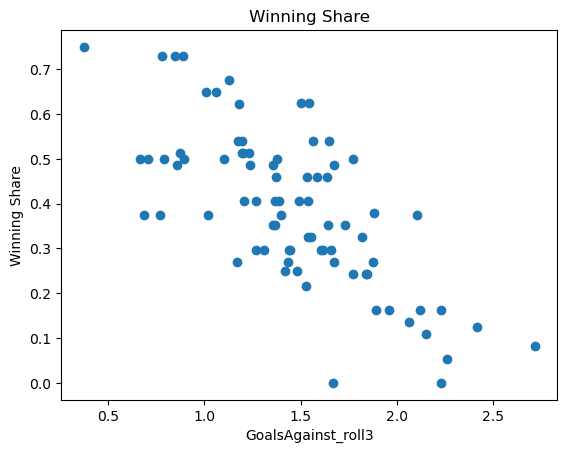

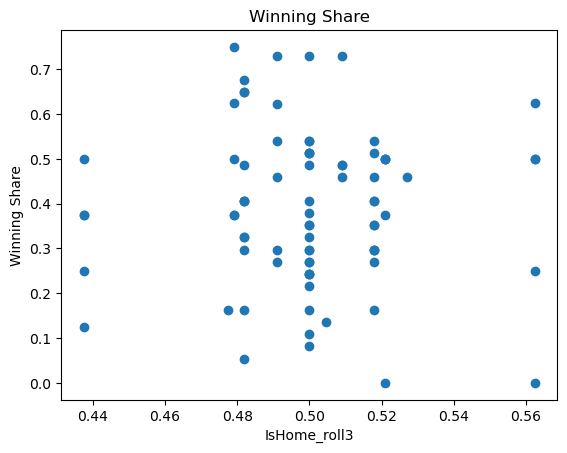

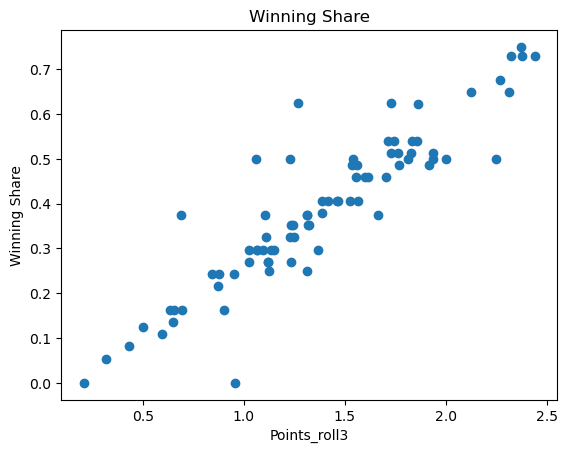

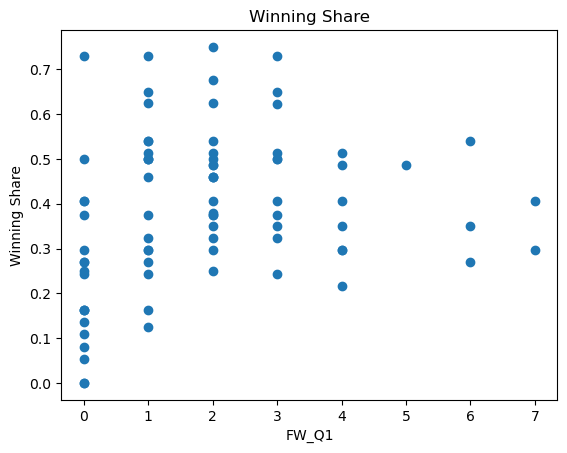

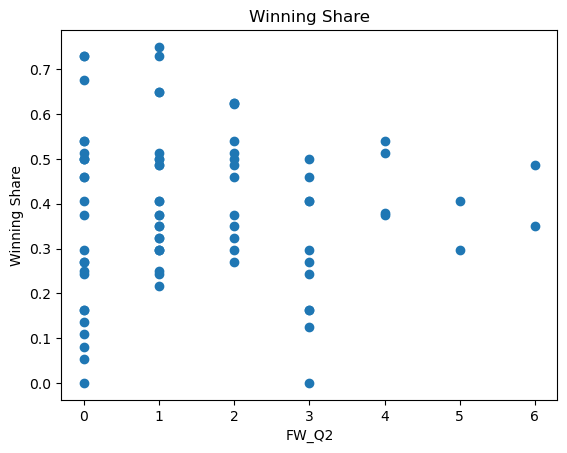

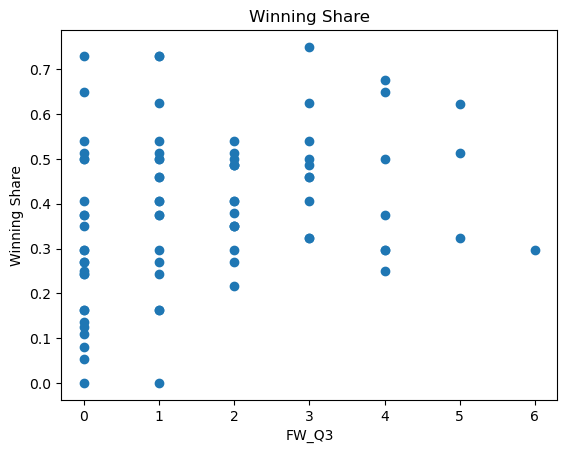

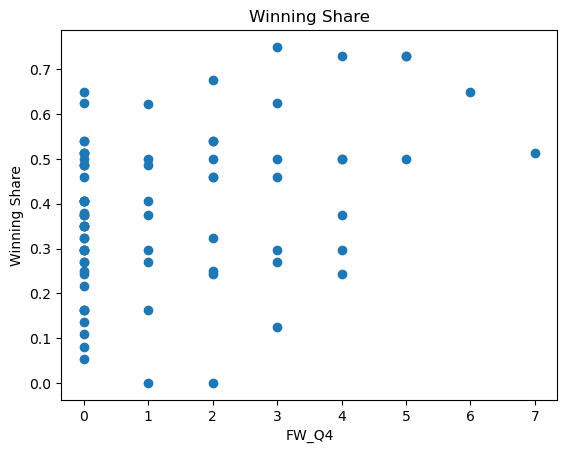

In [8]:
data_table = long_df[['Season','TeamID','Outcome', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'IsHome_roll3', 'Points_roll3',
                      'FW_Q1', 'FW_Q2', 'FW_Q3', 'FW_Q4']].dropna()
data_table.loc[:, 'Win'] = 0
data_table.loc[data_table['Outcome'] == 'W', 'Win'] = 1
data_table = data_table.groupby(['Season', 'TeamID']).agg(Win = ('Win', 'mean'),
                                                          IsHome_roll3 = ('IsHome_roll3', 'mean'),
                                                          GoalsFor_roll3 = ('GoalsFor_roll3', 'mean'),
                                                          GoalsAgainst_roll3 = ('GoalsAgainst_roll3', 'mean'),
                                                          Points_roll3 = ('Points_roll3', 'mean'),
                                                          FW_Q1 = ('FW_Q1', 'mean'),
                                                          FW_Q2 = ('FW_Q2', 'mean'),
                                                          FW_Q3 = ('FW_Q3', 'mean'),
                                                          FW_Q4 = ('FW_Q4', 'mean')
                                                          ).reset_index()
cols = ['GoalsFor_roll3', 'GoalsAgainst_roll3', 'IsHome_roll3', 'Points_roll3', 'FW_Q1', 'FW_Q2', 'FW_Q3', 'FW_Q4']
for col in cols:
    plt.scatter(x=data_table[col], y=data_table['Win'])

    plt.xlabel(f'{col}')
    plt.ylabel('Winning Share')
    plt.title('Winning Share')
    plt.show()

Distribution of outcomes for home games

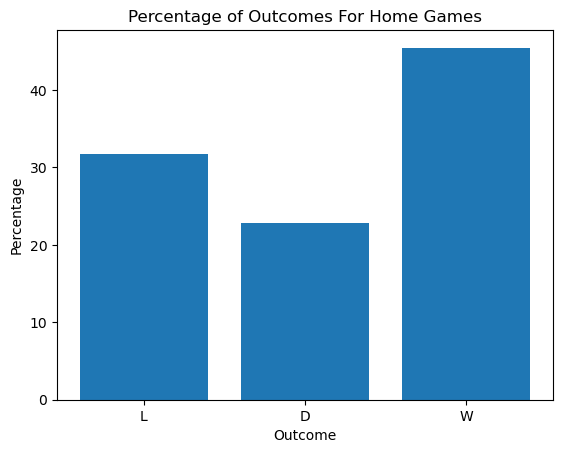

In [9]:
# for season in long_df['Season'].unique():
ishome_stats = long_df.groupby(['IsHome', 'Outcome']).agg(num=('TeamID', 'count')).reset_index()
ishome_stats = ishome_stats[ishome_stats['IsHome'] == True]

desired_order = ['L', 'D', 'W']
ishome_stats['Outcome'] = pd.Categorical(ishome_stats['Outcome'], categories=desired_order, ordered=True)
ishome_stats = ishome_stats.sort_values('Outcome').reset_index(drop=True)

# Calculate the percentage of each outcome
ishome_stats['percent'] = ishome_stats['num'] / ishome_stats['num'].sum() * 100

# Plot the horizontal bar chart
plt.bar(ishome_stats['Outcome'], ishome_stats['percent'])
plt.xlabel('Outcome')
plt.ylabel('Percentage')
plt.title(f'Percentage of Outcomes For Home Games')
plt.show()


# Estimation

## Models:
* K-Nearest Neighbour Model
* logit Regression
* Random Forest
* XGBoost

## Estimation Functions

In [10]:
# Build a small, reusable estimation pipeline to add/remove explanatory vars
#  - Change the FEATURES list in the runner cell to include/remove variables.
#  - Roll-3 features (ending with '_roll3') are discovered automatically.

roll3_cols = [col for col in long_df.columns if col.endswith('_roll3')]

# Default feature set (you can edit the runner cell to change which sets to try)
DEFAULT_FEATURES = ['Week', 'IsHome', 'TeamID', 'DayofWeek']

CATEGORICAL_VARS = ['Week', 'IsHome', 'TeamID', 'DayofWeek']  # treat Week, Team ID, DayofWeek, and IsHome as categorical

def build_dataset(df, features=None, categorical=CATEGORICAL_VARS):
    """Return X (with dummies applied), y, label encoder, label mapping, used raw features, and model columns.

    - 'features' is a list of raw dataframe columns you want to use (e.g. ['Week','IsHome','GoalsFor_roll3']).
    - categorical: list of columns that should be one-hot encoded.
    The function drops rows with NA in Outcome or any chosen raw feature before encoding.
    """
    if features is None:
        features = ['Week', 'IsHome', 'TeamID', 'DayofWeek'] + [c for c in df.columns if c.endswith('_roll3')]
    # ensure features exist in df
    present = [f for f in features if f in df.columns]
    missing = [f for f in features if f not in df.columns]
    if missing:
        print("Warning: the following features are missing from the dataframe and will be ignored:", missing)
    cols = ['Outcome'] + present
    data = df[cols].dropna().copy()

    # Separate X_raw and Y
    X_raw = data[present].copy()
    Y = data['Outcome']

    # One-hot encode categorical variables (only those present)
    cat_present = [c for c in categorical if c in X_raw.columns]
    if cat_present:
        X = pd.get_dummies(X_raw, columns=cat_present, dummy_na=False, drop_first=False)
    else:
        X = X_raw.astype(float)

    # Keep track of final model columns to ensure consistent prediction later
    model_columns = X.columns.tolist()

    # Ensure numeric dtype for downstream scalers/models
    X = X.astype(float)

    le = LabelEncoder()
    y = le.fit_transform(Y)
    label_mapping = {cls: int(i) for i, cls in enumerate(le.classes_)}
    return X, y, le, label_mapping, model_columns


def safe_train_test_split(X, y, test_size=0.2, random_state=173):
    try:
        return train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)
    except Exception as e:
        print("Stratified split failed (reason):", e)
        print("Falling back to a regular random split without stratification.")
        return train_test_split(X, y, test_size=test_size, random_state=random_state)


def train_models(X_train, y_train, use_xgb=True, use_rf=True):
    """Train KNN (scaled), Logistic (scaled), RandomForest (unscaled), and XGBoost (unscaled).
    Returns a dict with trained models and the scaler.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_scaled, y_train)

    # Logistic regression (try to use penalty='none' when available)
    log_reg = LogisticRegression(max_iter=2000)
    log_reg.fit(X_train_scaled, y_train)

    # Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=173)
    rf_clf.fit(X_train, y_train)  # RF can handle unscaled inputs

    # XGBoost
    xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    xgb_clf.fit(X_train, y_train)  # XGBoost can handle unscaled inputs

    nnet_clf = MLPClassifier(hidden_layer_sizes=(200,20,), 
                             early_stopping=True,
                             random_state=173)
    nnet_clf.fit(X_train_scaled, y_train)
    
    return {'scaler': scaler, 'knn': knn, 'log_reg': log_reg, 'rf': rf_clf, 'xgb': xgb_clf, 'nnet': nnet_clf}


def evaluate(models, X_test, y_test):
    scaler = models['scaler']
    X_test_scaled = scaler.transform(X_test)
    results = {}
    results['knn_acc'] = accuracy_score(y_test, models['knn'].predict(X_test_scaled))
    results['logreg_acc'] = accuracy_score(y_test, models['log_reg'].predict(X_test_scaled))
    results['rf_acc'] = accuracy_score(y_test, models['rf'].predict(X_test))
    results['xgb_acc'] = accuracy_score(y_test, models['xgb'].predict(X_test))
    results['nnet_acc'] = accuracy_score(y_test, models['nnet'].predict(X_test_scaled))
    return results


def predict_on_long_df(df, raw_features, model_columns, models, le, categorical=CATEGORICAL_VARS):
    """Create dummies for categorical vars on the full df using the raw_features list,
    then reindex to model_columns (adding missing columns with zeros) before scaling and predicting.
    """
    present = [f for f in raw_features if f in df.columns]
    X_all_raw = df[present].copy()

    # One-hot encode categorical variables present in the raw features
    cat_present = [c for c in categorical if c in X_all_raw.columns]
    if cat_present:
        X_all = pd.get_dummies(X_all_raw, columns=cat_present, dummy_na=False, drop_first=False)
    else:
        X_all = X_all_raw.copy()

    # Reindex to match the model training columns, fill missing with 0
    X_all = X_all.reindex(columns=model_columns).astype(float).fillna(0)

    scaler = models['scaler']
    X_scaled = scaler.transform(X_all)

    df['Predicted_knn']     = le.inverse_transform(models['knn'].predict(X_scaled))
    df['Predicted_logreg']  = le.inverse_transform(models['log_reg'].predict(X_scaled))
    df['Predicted_rf']      = le.inverse_transform(models['rf'].predict(X_all))
    df['Predicted_xgb']     = le.inverse_transform(models['xgb'].predict(X_all))
    df['Predicted_nnet']    = le.inverse_transform(models['nnet'].predict(X_scaled))
    
    return df

## Estimation

In [11]:
long_df.columns

Index(['Season', 'MatchID', 'Date', 'Week', 'DayofWeek', 'Team', 'TeamID',
       'IsHome', 'GoalsFor', 'GoalsAgainst', 'Outcome', 'Points',
       'IsHome_lag1', 'GoalsFor_lag1', 'GoalsAgainst_lag1', 'Points_lag1',
       'IsHome_roll3', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'Points_roll3',
       'FW_Q1', 'FW_Q2', 'FW_Q3', 'FW_Q4', 'MF_Q1', 'MF_Q2', 'MF_Q3'],
      dtype='object')

In [12]:
FEATURES_list ={
    # 'feature1': ['Week', 'IsHome', 'TeamID', 'DayofWeek', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'Points_roll3'],
    # 'feature2': ['Week', 'IsHome', 'TeamID', 'DayofWeek', 'FW_Q4', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'Points_roll3'],
    # 'feature3': ['Week', 'IsHome', 'TeamID', 'DayofWeek', 'FW_Q3', 'FW_Q4', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'Points_roll3'],
    # 'feature4': ['Week', 'IsHome', 'TeamID', 'DayofWeek', 'FW_Q2', 'FW_Q3', 'FW_Q4', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'Points_roll3'],
    'feature5': ['Week', 'IsHome', 'TeamID', 'DayofWeek', 'FW_Q1', 'FW_Q2', 'FW_Q3', 'FW_Q4', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'Points_roll3'],
    # 'feature6': ['Week', 'IsHome', 'TeamID', 'DayofWeek', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'Points_roll3'],
    # 'feature7': ['Week', 'IsHome', 'TeamID', 'DayofWeek', 'MF_Q3', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'Points_roll3'],
    # 'feature8': ['Week', 'IsHome', 'TeamID', 'DayofWeek', 'MF_Q2', 'MF_Q3', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'Points_roll3'],
    'feature9': ['Week', 'IsHome', 'TeamID', 'DayofWeek', 'MF_Q1', 'MF_Q2', 'MF_Q3', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'Points_roll3'],
    'feature10': ['Week', 'IsHome', 'TeamID', 'DayofWeek', 'FW_Q1', 'FW_Q2', 'FW_Q3', 'FW_Q4', 'MF_Q1', 'MF_Q2', 'MF_Q3', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'Points_roll3']
}

for name, FEATURES in FEATURES_list.items():
    print(f"\n=== Running pipeline with feature set: {name} ===")
    X, y, le, label_mapping, used_features = build_dataset(long_df, FEATURES)
    print("Used features:", used_features)
    print("Label mapping:", label_mapping)

    X_train, X_test, y_train, y_test = safe_train_test_split(X, y, test_size=0.2, random_state=173)

    models = train_models(X_train, y_train, use_xgb=True)

    results = evaluate(models, X_test, y_test)
    print("Evaluation results:", results)

    long_df = predict_on_long_df(long_df, used_features, X_test.columns.tolist(), models, le)

    # Quick confusion matrices for the test set
    sc = models['scaler']
    X_test_scaled = sc.transform(X_test)
    # print("KNN classification report:")
    # print(classification_report(y_test, models['knn'].predict(X_test_scaled), target_names=le.classes_))
    # print("Logistic Regression classification report:")
    # print(classification_report(y_test, models['log_reg'].predict(X_test_scaled), target_names=le.classes_))
    # print("XGBoost classification report:")
    # print(classification_report(y_test, models['xgb'].predict(X_test), target_names=le.classes_))


=== Running pipeline with feature set: feature5 ===
Used features: ['FW_Q1', 'FW_Q2', 'FW_Q3', 'FW_Q4', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'Points_roll3', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6', 'Week_7', 'Week_8', 'Week_9', 'Week_10', 'Week_11', 'Week_12', 'Week_13', 'Week_14', 'Week_15', 'Week_16', 'Week_17', 'Week_18', 'Week_19', 'Week_20', 'Week_21', 'Week_22', 'Week_23', 'Week_24', 'Week_25', 'Week_26', 'Week_27', 'Week_28', 'Week_29', 'Week_30', 'Week_31', 'Week_32', 'Week_33', 'Week_34', 'Week_35', 'Week_36', 'Week_37', 'Week_38', 'IsHome_False', 'IsHome_True', 'TeamID_1', 'TeamID_2', 'TeamID_3', 'TeamID_4', 'TeamID_5', 'TeamID_6', 'TeamID_7', 'TeamID_8', 'TeamID_9', 'TeamID_10', 'TeamID_11', 'TeamID_12', 'TeamID_13', 'TeamID_14', 'TeamID_15', 'TeamID_16', 'TeamID_17', 'TeamID_18', 'TeamID_19', 'TeamID_20', 'TeamID_21', 'TeamID_22', 'TeamID_23', 'TeamID_24', 'TeamID_25', 'DayofWeek_Fri', 'DayofWeek_Mon', 'DayofWeek_Sat', 'DayofWeek_Sun', 'DayofWeek_Thu', 'DayofWe

C:\Users\tavakola\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:199: UserWarning: [12:08:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^

Evaluation results: {'knn_acc': 0.37184873949579833, 'logreg_acc': 0.4684873949579832, 'rf_acc': 0.453781512605042, 'xgb_acc': 0.4327731092436975, 'nnet_acc': 0.43907563025210083}

=== Running pipeline with feature set: feature9 ===
Used features: ['MF_Q1', 'MF_Q2', 'MF_Q3', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'Points_roll3', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6', 'Week_7', 'Week_8', 'Week_9', 'Week_10', 'Week_11', 'Week_12', 'Week_13', 'Week_14', 'Week_15', 'Week_16', 'Week_17', 'Week_18', 'Week_19', 'Week_20', 'Week_21', 'Week_22', 'Week_23', 'Week_24', 'Week_25', 'Week_26', 'Week_27', 'Week_28', 'Week_29', 'Week_30', 'Week_31', 'Week_32', 'Week_33', 'Week_34', 'Week_35', 'Week_36', 'Week_37', 'Week_38', 'IsHome_False', 'IsHome_True', 'TeamID_1', 'TeamID_2', 'TeamID_3', 'TeamID_4', 'TeamID_5', 'TeamID_6', 'TeamID_7', 'TeamID_8', 'TeamID_9', 'TeamID_10', 'TeamID_11', 'TeamID_12', 'TeamID_13', 'TeamID_14', 'TeamID_15', 'TeamID_16', 'TeamID_17', 'TeamID_18', 'TeamID_19', 

C:\Users\tavakola\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:199: UserWarning: [12:08:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Evaluation results: {'knn_acc': 0.3739495798319328, 'logreg_acc': 0.44537815126050423, 'rf_acc': 0.47058823529411764, 'xgb_acc': 0.42016806722689076, 'nnet_acc': 0.46218487394957986}

=== Running pipeline with feature set: feature10 ===
Used features: ['FW_Q1', 'FW_Q2', 'FW_Q3', 'FW_Q4', 'MF_Q1', 'MF_Q2', 'MF_Q3', 'GoalsFor_roll3', 'GoalsAgainst_roll3', 'Points_roll3', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6', 'Week_7', 'Week_8', 'Week_9', 'Week_10', 'Week_11', 'Week_12', 'Week_13', 'Week_14', 'Week_15', 'Week_16', 'Week_17', 'Week_18', 'Week_19', 'Week_20', 'Week_21', 'Week_22', 'Week_23', 'Week_24', 'Week_25', 'Week_26', 'Week_27', 'Week_28', 'Week_29', 'Week_30', 'Week_31', 'Week_32', 'Week_33', 'Week_34', 'Week_35', 'Week_36', 'Week_37', 'Week_38', 'IsHome_False', 'IsHome_True', 'TeamID_1', 'TeamID_2', 'TeamID_3', 'TeamID_4', 'TeamID_5', 'TeamID_6', 'TeamID_7', 'TeamID_8', 'TeamID_9', 'TeamID_10', 'TeamID_11', 'TeamID_12', 'TeamID_13', 'TeamID_14', 'TeamID_15', 'TeamID_16',

C:\Users\tavakola\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:199: UserWarning: [12:08:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Evaluation results: {'knn_acc': 0.36764705882352944, 'logreg_acc': 0.4495798319327731, 'rf_acc': 0.4495798319327731, 'xgb_acc': 0.4222689075630252, 'nnet_acc': 0.44537815126050423}


# Look at Week 9 Fixtures and Predictions

In [18]:
match_df[(match_df['Season'] == '2025-2026') & (match_df['Wk'] == 10)]

,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Referee,Season
1230,10.0,Sat,2025-11-01,15:00,Crystal Palace,NaN,NaN,NaN,Brentford,NaN,NaN,2025-2026
1231,10.0,Sat,2025-11-01,15:00,Nott'ham Forest,NaN,NaN,NaN,Manchester Utd,NaN,NaN,2025-2026
1232,10.0,Sat,2025-11-01,15:00,Fulham,NaN,NaN,NaN,Wolves,NaN,NaN,2025-2026
1233,10.0,Sat,2025-11-01,15:00,Burnley,NaN,NaN,NaN,Arsenal,NaN,NaN,2025-2026
1234,10.0,Sat,2025-11-01,15:00,Brighton,NaN,NaN,NaN,Leeds United,NaN,NaN,2025-2026
1235,10.0,Sat,2025-11-01,17:30,Tottenham,NaN,NaN,NaN,Chelsea,NaN,NaN,2025-2026
1236,10.0,Sat,2025-11-01,20:00,Liverpool,NaN,NaN,NaN,Aston Villa,NaN,NaN,2025-2026
1237,10.0,Sun,2025-11-02,14:00,West Ham,NaN,NaN,NaN,Newcastle Utd,NaN,NaN,2025-2026
1238,10.0,Sun,2025-11-02,16:30,Manchester City,NaN,NaN,NaN,Bournemouth,NaN,NaN,2025-2026
1239,10.0,Mon,2025-11-03,20:00,Sunderland,NaN,NaN,NaN,Everton,NaN,NaN,2025-2026


In [19]:
# long_df[['Outcome', 'Predicted_knn', 'Predicted_logreg', 'Predicted_rf', 'Predicted_xgb']]
long_df[(long_df['Season'] == '2025-2026') & (long_df['Week'] == 10)][['Team', 'Outcome', 'Predicted_knn', 'Predicted_logreg', 'Predicted_rf', 'Predicted_xgb', 'Predicted_nnet']]

,Team,Outcome,Predicted_knn,Predicted_logreg,Predicted_rf,Predicted_xgb,Predicted_nnet
2289,Arsenal,None,W,L,W,W,W
2327,Aston Villa,None,W,L,W,W,W
2365,Bournemouth,None,W,W,W,L,W
2403,Brentford,None,W,L,W,W,W
2441,Brighton,None,L,W,W,W,W
2479,Burnley,None,L,W,L,L,L
2517,Chelsea,None,W,W,W,W,W
2555,Crystal Palace,None,L,W,L,L,W
2593,Everton,None,W,W,W,W,W
2631,Fulham,None,L,W,L,W,D


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

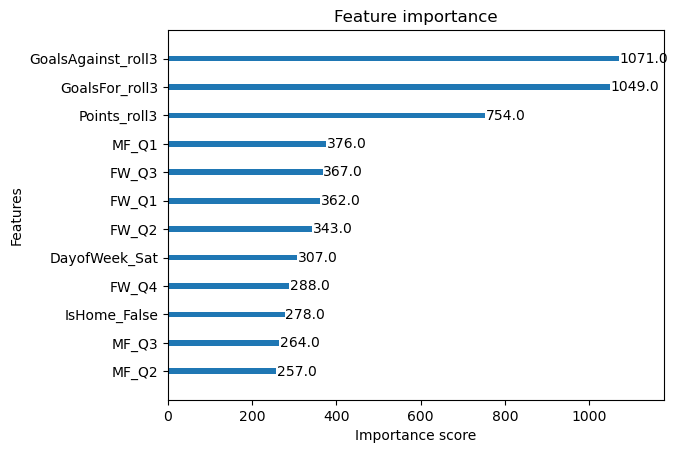

In [15]:
xgb.plot_importance(models['xgb'], max_num_features=12, grid=False)

# Neural Network

In [ ]:
import skorch
from skorch import NeuralNetClassifier
import torch
import torch.nn as nn

class SimpleNNModule(nn.Module):
    def __init__(self, input_dim, hidden_dim1=200, hidden_dim2=20, output_dim=3):
        super(SimpleNNModule, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

snnet = SimpleNNModule(input_dim=X_train.shape[1], output_dim=len(le.classes_))
nnet_clf = NeuralNetClassifier(
    module=snnet,
    max_epochs=20,
    lr=0.01,
    iterator_train__shuffle=True,
    verbose=1,
    device='cpu'  # change to 'cuda' if GPU is available
)
nnet_clf.fit(X_train.astype(np.float32), y_train.astype(np.longlong))
y_pred = nnet_clf.predict(X_test.astype(np.float32))

print("Neural Network classification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


OSError: [WinError 1114] A dynamic link library (DLL) initialization routine failed. Error loading "C:\Users\tavakola\AppData\Roaming\Python\Python311\site-packages\torch\lib\c10.dll" or one of its dependencies.